# Setup

In [1]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 8.6 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
!echo "{\"username\":\"dachisuramelashvili\",\"key\":\"27a42d5900c0e3a2b31cb91648b983ef\"}" > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c gan-getting-started

 99% 365M/367M [00:09<00:00, 42.4MB/s]
100% 367M/367M [00:09<00:00, 40.8MB/s]


In [4]:
!unzip gan-getting-started.zip

Streaming output truncated to the last 5000 lines.
  inflating: photo_jpg/46e71a4094.jpg  
  inflating: photo_jpg/46e84039a1.jpg  
  inflating: photo_jpg/46f391abec.jpg  
  inflating: photo_jpg/46f5ef1042.jpg  
  inflating: photo_jpg/4706619607.jpg  
  inflating: photo_jpg/4707b03a08.jpg  
  inflating: photo_jpg/47100a9939.jpg  
  inflating: photo_jpg/471f4755b9.jpg  
  inflating: photo_jpg/472b351bc4.jpg  
  inflating: photo_jpg/472d5ac100.jpg  
  inflating: photo_jpg/4758e5dd4c.jpg  
  inflating: photo_jpg/4762bb79ef.jpg  
  inflating: photo_jpg/4778b13518.jpg  
  inflating: photo_jpg/4787b82d37.jpg  
  inflating: photo_jpg/478e07feaa.jpg  
  inflating: photo_jpg/478eb12a82.jpg  
  inflating: photo_jpg/479698b371.jpg  
  inflating: photo_jpg/4796d67f61.jpg  
  inflating: photo_jpg/47aad493bd.jpg  
  inflating: photo_jpg/47ae0edd23.jpg  
  inflating: photo_jpg/47b94957ff.jpg  
  inflating: photo_jpg/47bb43fe3e.jpg  
  inflating: photo_jpg/47bb59d449.jpg  
  inflating: photo_jpg/47d391

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import pandas as pd
import torch as torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import random
import os
import time
from skimage import io, color, filters
import zipfile
from PIL import Image
from tqdm import tqdm
import wandb
from torchsummary import summary
import io
from contextlib import redirect_stdout

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [43]:
BATCH_SIZE = 1
EPOCHS = 20

# Save and Load

In [10]:
def load_checkpoint(ckpt_path, map_location=None):
    ckpt = torch.load(ckpt_path, map_location=map_location)
    print(' [*] Loading checkpoint from %s succeed!' % ckpt_path)
    return ckpt

In [11]:
def save_checkpoint(state, save_path):
    torch.save(state, save_path)

# Data

In [12]:
dataset_path = ""

# List all image files in the dataset directory
photo_dir = os.path.join(dataset_path, "photo_jpg")
monet_dir = os.path.join(dataset_path, "monet_jpg")
photo_files = [os.path.join(photo_dir, file) for file in os.listdir(photo_dir) if file.endswith(('.jpg'))]
monet_files = [os.path.join(monet_dir, file) for file in os.listdir(monet_dir) if file.endswith(('.jpg'))]

# Create a pandas DataFrame with the image file paths
photo_df = pd.DataFrame({'image_path': photo_files})
monet_df = pd.DataFrame({'image_path': monet_files})

photo_df.head(), monet_df.head()

(                 image_path
 0  photo_jpg/9f98b589a1.jpg
 1  photo_jpg/0723d52098.jpg
 2  photo_jpg/72d466fe84.jpg
 3  photo_jpg/277d120bb4.jpg
 4  photo_jpg/47100a9939.jpg,
                  image_path
 0  monet_jpg/a202b1b200.jpg
 1  monet_jpg/7239ba0b55.jpg
 2  monet_jpg/599098859e.jpg
 3  monet_jpg/3deea9f4a4.jpg
 4  monet_jpg/eb3cc5c559.jpg)

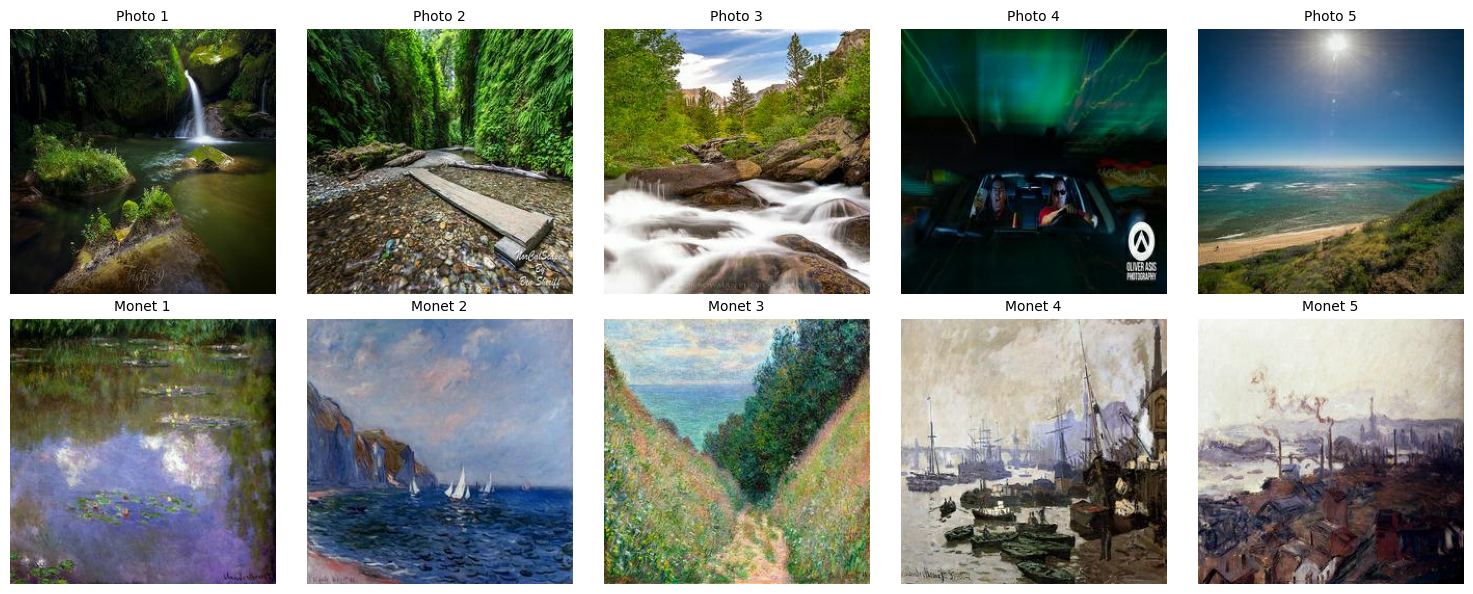

In [13]:
photo_examples = photo_df.sample(n=5)
monet_examples = monet_df.sample(n=5)

photo_examples_images = [Image.open(path) for path in photo_examples['image_path']]
monet_examples_images = [Image.open(path) for path in monet_examples['image_path']]

all_images = photo_examples_images + monet_examples_images

titles = [f'Photo {i+1}' for i in range(5)] + \
         [f'Monet {i+1}' for i in range(5)]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axes = axes.flatten()

for i, (img, title) in enumerate(zip(all_images, titles)):
    axes[i].imshow(img)
    axes[i].set_title(title, fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [14]:
class ImageDataset(Dataset):
  def __init__(
    self,
    monet_dir, photo_dir,
    size=(256, 256),
    normalize=True,
    augment=False,
    ):
    super().__init__()
    self.monet_dir = monet_dir
    self.photo_dir = photo_dir
    self.monet_idx = dict()
    self.photo_idx = dict()
    self.augment = augment

    base_transforms = [transforms.Resize(size)]

    if augment:
        augment_transforms = [
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomRotation(degrees=15),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        ]
        base_transforms.extend(augment_transforms)

    base_transforms.append(transforms.ToTensor())
    if normalize:
        base_transforms.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))

    self.transform = transforms.Compose(base_transforms)

    for i, fl in enumerate(os.listdir(self.monet_dir)):
      self.monet_idx[i] = fl
    for i, fl in enumerate(os.listdir(self.photo_dir)):
      self.photo_idx[i] = fl
    self.len = min(len(self.monet_idx.keys()), len(self.photo_idx.keys()))

  def __getitem__(self, idx):
    rand_idx = int(np.random.uniform(0, self.len))
    photo_path = os.path.join(self.photo_dir, self.photo_idx[idx])
    monet_path = os.path.join(self.monet_dir, self.monet_idx[rand_idx])
    photo_img = Image.open(photo_path)
    monet_img = Image.open(monet_path)

    if self.augment:
        rand_state = torch.get_rng_state()
        photo_img = self.transform(photo_img)
        torch.set_rng_state(rand_state)
        monet_img = self.transform(monet_img)
    else:
        photo_img = self.transform(photo_img)
        monet_img = self.transform(monet_img)

    return photo_img, monet_img

  def __len__(self):
    return self.len

In [15]:
img_ds = ImageDataset(monet_dir, photo_dir)
img_ds[0][0].shape, img_ds[0][1].shape

(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))

In [16]:
img_dl = DataLoader(img_ds, batch_size=BATCH_SIZE, shuffle=True)

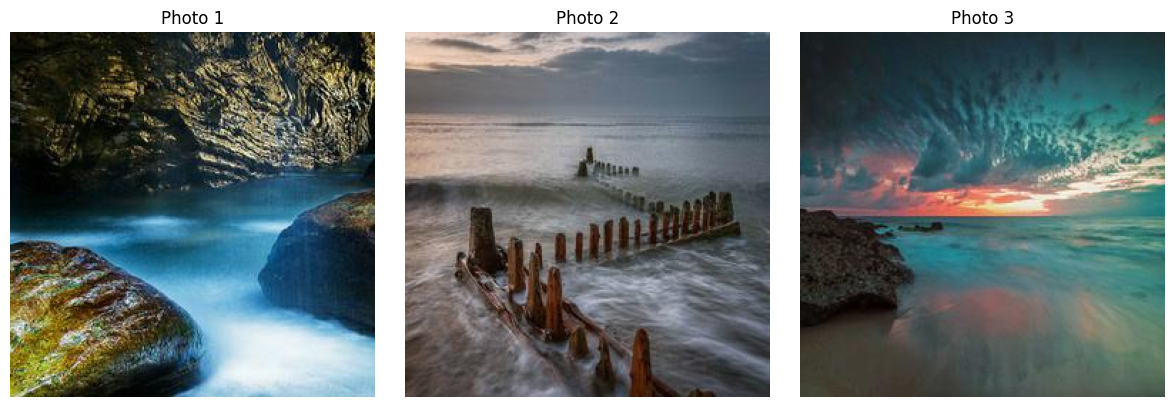

In [17]:
start = 0
val_photos = [img_ds[i][0] for i in range(start, start + 3)]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, img in enumerate(val_photos):
    # Unnormalize for display
    img_disp = img.cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5
    axes[i].imshow(np.clip(img_disp, 0, 1))
    axes[i].axis('off')
    axes[i].set_title(f'Photo {i+1}')
plt.tight_layout()
plt.show()

# Models

## Blocks

### Down Block

In [18]:
class Downblock(nn.Module):
    def __init__(
        self,
        # dims
        in_ch, out_ch,
        # conv
        kernel_size=3, stride=1, padding=0, use_bias=True,
        # norm
        apply_norm=True, use_inst_norm=True,
        # activation
        activation='relu',
        # dropout
        dropout_ratio=0.0
        ):
        super().__init__()
        layers = []

        # 1. conv (better padding)
        layers.append(nn.ReflectionPad2d(padding))
        layers.append(nn.Conv2d(
            in_ch, out_ch,
            kernel_size, stride, 0,
            bias=use_bias,
            padding_mode='reflect'
        ))

        # 2. norm
        if apply_norm:
            if use_inst_norm:
                layers.append(nn.InstanceNorm2d(out_ch, affine=True))
            else:
                layers.append(nn.BatchNorm2d(out_ch))

        # 3. activation
        if activation != '':
            if activation == 'gelu':
                layers.append(nn.GELU())
            elif activation == 'leaky':
                layers.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
            else:
                layers.append(nn.ReLU(inplace=True))

        # 4. dropout
        if dropout_ratio > 0.0:
            layers.append(nn.Dropout(dropout_ratio))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

### Residual Block

In [20]:
class Resblock(nn.Module):
    def __init__(
        self,
        # dims
        in_features,
        # norm
        use_inst_norm=True,
        # activation
        use_gelu=True,
        # dropout
        dropout_ratio=0.5
        ):
        super().__init__()

        # 1. refl pad + down block (activation + dropout)
        layers = list()
        layers.append(Downblock(
            in_ch=in_features, out_ch=in_features,
            kernel_size=3, stride=1, padding=1, use_bias=True,
            apply_norm=True, use_inst_norm=use_inst_norm,
            activation='gelu' if use_gelu else 'relu',
            dropout_ratio=dropout_ratio
        ))

        # 2. refl pad + down block
        layers.append(Downblock(
            in_ch=in_features, out_ch=in_features,
            kernel_size=3, stride=1, padding=1, use_bias=True,
            apply_norm=True, use_inst_norm=use_inst_norm,
            activation='',
            dropout_ratio=0.0
        ))

        self.res = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.res(x)

### Up Block

In [21]:
class Upblock(nn.Module):
    def __init__(
        self,
        # dims
        in_ch, out_ch,
        # conv transpose
        kernel_size=3, stride=2, padding=1, output_padding=1, use_bias=True,
        # norm
        apply_norm=True, use_inst_norm=True,
        # activation
        activation='gelu',
        # dropout
        dropout_ratio=0.5,
        # UNet specific
        is_pre_activation=False
        ):
        super().__init__()
        layers = []

        # 1. conv transpose
        layers.append(nn.ConvTranspose2d(
            in_ch, out_ch,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
            bias=use_bias
        ))

        # 1. upsample + conv (checkerboard fix)
        # layers.append(nn.Upsample(scale_factor=stride, mode='nearest'))
        # layers.append(nn.Conv2d(
        #     in_ch, out_ch,
        #     kernel_size=kernel_size,
        #     stride=1,
        #     padding=padding,
        #     bias=use_bias
        # ))


        # 2. norm
        if apply_norm:
            if use_inst_norm:
                layers.append(nn.InstanceNorm2d(out_ch))
            else:
                layers.append(nn.BatchNorm2d(out_ch))

        # 3. activation
        if activation != '':
            if activation == 'gelu':
                act = nn.GELU()
            else:
                act = nn.ReLU(inplace=True)

            if is_pre_activation:
                layers.insert(1, act)
            else:
                layers.append(act)

        # 4. Dropout
        if dropout_ratio > 0.0:
            layers.append(nn.Dropout(dropout_ratio))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## Generator

### ResNet Based Generator

In [ ]:
class ResNetGenerator(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, n_resblocks=6, dropout=0.5):
        super().__init__()

        model = list()
        model.append(nn.ReflectionPad2d(3))

        # Downsampling
        model.append(Downblock(
            in_ch=in_ch, out_ch=64,
            kernel_size=7, stride=1, padding=0, use_bias=True,
            apply_norm=True, use_inst_norm=True,
            activation='gelu',
            dropout_ratio=0.0
        ))
        model.append(Downblock(
            in_ch=64, out_ch=128,
            kernel_size=3, stride=2, padding=1, use_bias=True,
            apply_norm=True, use_inst_norm=True,
            activation='gelu',
            dropout_ratio=0.0
        ))
        model.append(Downblock(
            in_ch=128, out_ch=256,
            kernel_size=3, stride=2, padding=1, use_bias=True,
            apply_norm=True, use_inst_norm=True,
            activation='gelu',
            dropout_ratio=0.0
        ))

        # Residual blocks
        for _ in range(n_resblocks):
            model.append(Resblock(
                in_features=256,
                use_inst_norm=True,
                use_gelu=True,
                dropout_ratio=0.0
            ))

        # Upsampling
        model.append(Upblock(
            in_ch=256, out_ch=128,
            kernel_size=3, stride=2, padding=1, output_padding=1, use_bias=True,
            apply_norm=True, use_inst_norm=True,
            activation='gelu',
            dropout_ratio=dropout
        ))
        model.append(Upblock(
            in_ch=128, out_ch=64,
            kernel_size=3, stride=2, padding=1, output_padding=1, use_bias=True,
            apply_norm=True, use_inst_norm=True,
            activation='gelu',
            dropout_ratio=dropout
        ))
        model.append(nn.ReflectionPad2d(3))
        model.append(nn.Conv2d(64, out_ch, kernel_size=7, stride=1, padding=0))

        # Scale output to [-1, 1]
        model.append(nn.Tanh())

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [24]:
resnet = ResNetGenerator(3,3).to(device)
summary(resnet, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 262, 262]               0
   ReflectionPad2d-2          [-1, 3, 262, 262]               0
            Conv2d-3         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-4         [-1, 64, 256, 256]             128
              GELU-5         [-1, 64, 256, 256]               0
         Downblock-6         [-1, 64, 256, 256]               0
   ReflectionPad2d-7         [-1, 64, 258, 258]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-9        [-1, 128, 128, 128]             256
             GELU-10        [-1, 128, 128, 128]               0
        Downblock-11        [-1, 128, 128, 128]               0
  ReflectionPad2d-12        [-1, 128, 130, 130]               0
           Conv2d-13          [-1, 256, 64, 64]         295,168
   InstanceNorm2d-14          [-1, 256,

### U-Net Based Generator

In [25]:
class UNetGenerator(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, num_downs=7, dropout=0.5):
        super().__init__()

        self.num_downs = num_downs

        base_ch = 64

        # Encoder/Decoder channel progression
        enc_in_chs = [in_ch] + [base_ch * min(2**i, 8) for i in range(num_downs-1)]
        enc_out_chs = [base_ch * min(2**i, 8) for i in range(num_downs)]

        dec_in_chs = [enc_out_chs[::-1][0]] + [c * 2 for c in enc_out_chs[::-1][1:]]
        dec_out_chs = enc_in_chs[::-1]

        # Encoder
        self.encoder = nn.ModuleList()
        for i in range(num_downs):
            use_norm = i > 0 and i < num_downs - 1 # No norm in first layer or last layer (bottleneck)
            activation = 'leaky' if i != num_downs - 1 else 'relu'
            self.encoder.append(
                Downblock(
                    in_ch=enc_in_chs[i], out_ch=enc_out_chs[i],
                    kernel_size=4, stride=2, padding=1, use_bias=False,
                    apply_norm=use_norm, use_inst_norm=True,
                    activation=activation,
                    dropout_ratio=0.0
                )
            )

        # Decoder
        self.decoder = nn.ModuleList()
        for i in range(num_downs):
            use_dropout = i < 3 # First 3 decoder layers have dropout
            apply_norm = i != num_downs - 1 # No norm in final layer
            activation = '' if i == num_downs - 1 else 'relu' # No activation in final layer
            self.decoder.append(
                Upblock(
                    in_ch=dec_in_chs[i], out_ch=dec_out_chs[i],
                    kernel_size=3, stride=2, padding=1, output_padding=0, use_bias=False,
                    apply_norm=apply_norm, use_inst_norm=True,
                    activation=activation,
                    dropout_ratio=dropout if use_dropout else 0.0,
                    is_pre_activation=True
                )
            )

        self.tanh = nn.Tanh()

    def forward(self, x):
        # Encoder output for skip connections
        encoder_outputs = []

        # Encoder forward pass
        current = x
        for encoder_block in self.encoder:
            current = encoder_block(current)
            encoder_outputs.append(current)

        # Decoder forward pass with skip connections
        for i, decoder_block in enumerate(self.decoder):
            current = decoder_block(current)
            skip_idx = len(encoder_outputs) - 1 - i - 1
            if skip_idx >= 0:
                current = torch.cat([current, encoder_outputs[skip_idx]], dim=1)

        # Tanh activation at the end
        output = self.tanh(current)

        return output

In [26]:
unet = UNetGenerator(3,3).to(device)
summary(unet, (3, 256, 256))

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 3 but got size 4 for tensor number 1 in the list.

## Discriminator

In [28]:
class Discriminator(nn.Module):
    def __init__(self, in_ch=3):
        super().__init__()

        model = list()

        # Downsampling
        model.append(Downblock(
            in_ch=in_ch, out_ch=64,
            kernel_size=4, stride=2, padding=1, use_bias=True,
            apply_norm=False, # no norm in first layer for better stability
            activation='leaky',
            dropout_ratio=0.0
        ))
        model.append(Downblock(
            in_ch=64, out_ch=128,
            kernel_size=4, stride=2, padding=1, use_bias=True,
            apply_norm=True, use_inst_norm=True,
            activation='leaky',
            dropout_ratio=0.0
        ))
        model.append(Downblock(
            in_ch=128, out_ch=256,
            kernel_size=4, stride=2, padding=1, use_bias=True,
            apply_norm=True, use_inst_norm=True,
            activation='leaky',
            dropout_ratio=0.0
        ))
        model.append(Downblock(
            in_ch=256, out_ch=512,
            kernel_size=4, stride=1, padding=1, use_bias=True,
            apply_norm=True, use_inst_norm=True,
            activation='leaky',
            dropout_ratio=0.0
        ))

        # Output layer
        model.append(nn.Conv2d(
            in_channels=512, out_channels=1,
            kernel_size=4, stride=1, padding=1
        ))

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

## Adversarial Losses

In [29]:
class AdversarialLosses:
    def __init__(
        self,
        adversarial_loss_type = 'lsgan' # Options: 'lsgan', 'hinge', 'vanilla'
        ):
        self.adversarial_loss_type = adversarial_loss_type

    def gen_adv_loss(self, fake_pred):
        """Compute adversarial loss for generator based on loss type"""
        if self.adversarial_loss_type == 'lsgan':
            return self.mse_loss(fake_pred, target_is_real=True)
        elif self.adversarial_loss_type == 'hinge':
            return self.hinge_loss_generator(fake_pred)
        elif self.adversarial_loss_type == 'vanilla':
            return self.vanilla_gan_loss(fake_pred, target_is_real=True)
        else:
            raise ValueError(f"Unknown adversarial loss type: {self.adversarial_loss_type}")

    def disc_adv_loss(self, real_pred, fake_pred):
        """Compute adversarial loss for discriminator based on loss type"""
        if self.adversarial_loss_type == 'lsgan':
            real_loss = self.mse_loss(real_pred, target_is_real=True)
            fake_loss = self.mse_loss(fake_pred, target_is_real=False)
            return (real_loss + fake_loss) * 0.5
        elif self.adversarial_loss_type == 'hinge':
            return self.hinge_loss_discriminator(real_pred, fake_pred)
        elif self.adversarial_loss_type == 'vanilla':
            real_loss = self.vanilla_gan_loss(real_pred, target_is_real=True)
            fake_loss = self.vanilla_gan_loss(fake_pred, target_is_real=False)
            return (real_loss + fake_loss) * 0.5
        else:
            raise ValueError(f"Unknown adversarial loss type: {self.adversarial_loss_type}")

    @staticmethod
    def mse_loss(pred, target_is_real):
        """LSGAN loss (Least Squares GAN)"""
        if target_is_real:
            target = torch.ones_like(pred)
        else:
            target = torch.zeros_like(pred)
        return nn.MSELoss()(pred, target)

    @staticmethod
    def hinge_loss_discriminator(real_pred, fake_pred):
        """Hinge loss for discriminator"""
        real_loss = torch.mean(torch.relu(1.0 - real_pred))
        fake_loss = torch.mean(torch.relu(1.0 + fake_pred))
        return (real_loss + fake_loss) * 0.5

    @staticmethod
    def hinge_loss_generator(fake_pred):
        """Hinge loss for generator"""
        return -torch.mean(fake_pred)

    @staticmethod
    def vanilla_gan_loss(pred, target_is_real):
        """Standard GAN loss with BCE"""
        if target_is_real:
            target = torch.ones_like(pred)
        else:
            target = torch.zeros_like(pred)
        return nn.BCEWithLogitsLoss()(pred, target)

## CycleGAN

### Helpers

In [30]:
class lr_sched():
    def __init__(self, total_epochs=200):
        self.total_epochs = total_epochs
        self.decay_epochs = total_epochs/2

    def step(self, epoch_num):
        if epoch_num <= self.decay_epochs:
            return 1.0
        else:
            fract = (epoch_num - self.decay_epochs)  / (self.total_epochs - self.decay_epochs)
            return 1.0 - fract

In [31]:
def update_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

In [32]:
class sample_fake(object):
    def __init__(self, max_imgs=50):
        self.max_imgs = max_imgs
        self.cur_img = 0
        self.imgs = list()

    def __call__(self, imgs):
        ret = list()
        for img in imgs:
            if self.cur_img < self.max_imgs:
                self.imgs.append(img)
                ret.append(img)
                self.cur_img += 1
            else:
                if np.random.ranf() > 0.5:
                    idx = np.random.randint(0, self.max_imgs)
                    ret.append(self.imgs[idx])
                    self.imgs[idx] = img
                else:
                    ret.append(img)
        return ret

In [33]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                nn.init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            nn.init.normal_(m.weight.data, 1.0, gain)
            nn.init.constant_(m.bias.data, 0.0)
    net.apply(init_func)

### Model

In [ ]:
class CycleGAN(nn.Module):
    def __init__(
        self,
        # generator
        in_ch=3, out_ch=3,
        epochs=20, lr=0.0002,
        cycle_weight=10.0, id_weight=5.0, adv_weight = 1.0,
        adversarial_loss_type='lsgan', # Options: 'lsgan', 'hinge', 'vanilla'
        dropout=0.5
        ):
        super().__init__()

        self.epochs = epochs
        self.lr = lr
        self.cycle_weight = cycle_weight
        self.id_weight = id_weight
        self.adv_weight = adv_weight

        self.g_ptm = ResNetGenerator(in_ch, out_ch, dropout=dropout).to(device)
        self.g_mtp = ResNetGenerator(out_ch, in_ch, dropout=dropout).to(device)
        self.d_m = Discriminator(in_ch).to(device)
        self.d_p = Discriminator(out_ch).to(device)

        init_weights(self.g_ptm)
        init_weights(self.g_mtp)
        init_weights(self.d_m)
        init_weights(self.d_p)

        self.l1_loss = nn.L1Loss()
        self.adversarial_loss = AdversarialLosses(adversarial_loss_type=adversarial_loss_type)

        self.adam_g = optim.Adam(
            list(self.g_ptm.parameters()) + list(self.g_mtp.parameters()),
            lr=self.lr, betas=(0.5, 0.999)
        )
        self.adam_d = optim.Adam(
            list(self.d_m.parameters()) + list(self.d_p.parameters()),
            lr=self.lr, betas=(0.5, 0.999)
        )

        self.gen_lr_scheduler = optim.lr_scheduler.LambdaLR(
            self.adam_g,
            lr_lambda=lr_sched(self.epochs).step
        )
        self.disc_lr_scheduler = optim.lr_scheduler.LambdaLR(
            self.adam_d,
            lr_lambda=lr_sched(self.epochs).step
        )

        self.sample_m = sample_fake()
        self.sample_p = sample_fake()

        self.gen_avg_losses = []
        self.disc_avg_losses = []

    def train(self, x, log_wandb=False, val_photos: list[torch.Tensor] | None = None):
        for epoch in range(self.epochs):
            start_time = time.time()

            gen_losses_identity = []
            gen_losses_cycle = []
            gen_losses_adversarial = []
            gen_losses = []

            disc_losses = []

            t = tqdm(x, leave=False, total=len(x))

            for i, (p_real, m_real) in enumerate(t):
                p_real = p_real.to(device)
                m_real = m_real.to(device)

                # Train Generator only
                update_req_grad([self.g_ptm, self.g_mtp], True)
                update_req_grad([self.d_m, self.d_p], False)
                self.adam_g.zero_grad()

                # Forward pass through generators
                m_fake = self.g_ptm(p_real)
                p_fake = self.g_mtp(m_real)

                m_cycle = self.g_ptm(p_fake)
                p_cycle = self.g_mtp(m_fake)

                m_identity = self.g_ptm(m_real)
                p_identity = self.g_mtp(p_real)

                # GenLoss = Adversarial + Cycle Consistency + Identity
                m_loss_identity = self.l1_loss(m_identity, m_real) * self.id_weight
                p_loss_identity = self.l1_loss(p_identity, p_real) * self.id_weight

                m_loss_cycle = self.l1_loss(m_cycle, m_real) * self.cycle_weight
                p_loss_cycle = self.l1_loss(p_cycle, p_real) * self.cycle_weight

                m_discriminated = self.d_m(m_fake)
                p_discriminated = self.d_p(p_fake)

                m_loss_adversarial = self.adversarial_loss.gen_adv_loss(m_discriminated) * self.adv_weight
                p_loss_adversarial = self.adversarial_loss.gen_adv_loss(p_discriminated) * self.adv_weight

                total_gen_loss = m_loss_identity + p_loss_identity + \
                                 m_loss_cycle + p_loss_cycle + \
                                 m_loss_adversarial + p_loss_adversarial

                gen_losses_identity.append(m_loss_identity.item() + p_loss_identity.item())
                gen_losses_cycle.append(m_loss_cycle.item() + p_loss_cycle.item())
                gen_losses_adversarial.append(m_loss_adversarial.item() + p_loss_adversarial.item())
                gen_losses.append(total_gen_loss.item())

                # Backward pass through generators
                total_gen_loss.backward()
                self.adam_g.step()

                # Train Discriminators only
                update_req_grad([self.g_ptm, self.g_mtp], False)
                update_req_grad([self.d_m, self.d_p], True)
                self.adam_d.zero_grad()

                # Forward pass through discriminators
                m_fake = self.sample_m([m_fake.cpu().data.numpy()])[0]
                p_fake = self.sample_p([p_fake.cpu().data.numpy()])[0]
                m_fake = torch.tensor(m_fake).to(device)
                p_fake = torch.tensor(p_fake).to(device)

                m_disc_real = self.d_m(m_real)
                m_disc_fake = self.d_m(m_fake)
                p_disc_real = self.d_p(p_real)
                p_disc_fake = self.d_p(p_fake)

                # Discriminator Loss
                m_disc_loss = self.adversarial_loss.disc_adv_loss(m_disc_real, m_disc_fake)
                p_disc_loss = self.adversarial_loss.disc_adv_loss(p_disc_real, p_disc_fake)

                total_disc_loss = m_disc_loss + p_disc_loss
                disc_losses.append(total_disc_loss.item())

                # Backward pass through discriminators
                m_disc_loss.backward()
                p_disc_loss.backward()
                self.adam_d.step()

                t.set_postfix(gen_loss=total_gen_loss.item(), disc_loss=total_disc_loss.item())

            if (epoch+1) % 5 == 0:
                save_dict = {
                    'g_ptm': self.g_ptm.state_dict(),
                    'g_mtp': self.g_mtp.state_dict(),
                    'd_m': self.d_m.state_dict(),
                    'd_p': self.d_p.state_dict(),
                    'adam_g': self.adam_g.state_dict(),
                    'adam_d': self.adam_d.state_dict(),
                    'epoch': epoch + 1
                }

                save_checkpoint(save_dict, f"checkpoint_epoch_{epoch+1}.pth")

            avg_gen_loss_identity = np.mean(gen_losses_identity)
            avg_gen_loss_cycle = np.mean(gen_losses_cycle)
            avg_gen_loss_adversarial = np.mean(gen_losses_adversarial)

            avg_gen_loss = np.mean(gen_losses)
            avg_disc_loss = np.mean(disc_losses)

            self.gen_avg_losses.append(avg_gen_loss)
            self.disc_avg_losses.append(avg_disc_loss)

            end_time = time.time()
            elapsed_time = end_time - start_time

            if log_wandb:
                metrics = {
                    "Epoch": epoch + 1,

                    "Loss/G/Total": avg_gen_loss,
                    "Loss/G/Identity": avg_gen_loss_identity,
                    "Loss/G/Cycle": avg_gen_loss_cycle,
                    "Loss/G/Adversarial": avg_gen_loss_adversarial,

                    "Loss/D/Total": avg_disc_loss,

                    "Time": elapsed_time
                }

                wandb.log(metrics)

                if val_photos is not None:
                    self.g_ptm.eval()
                    self.g_mtp.eval()
                    with torch.no_grad():
                        generated_images = []
                        for i, img in enumerate(val_photos):
                            monet_gen = self.g_ptm(img.unsqueeze(0).to(device))
                            cycle_gen = self.g_mtp(monet_gen)
                            identity_gen = self.g_mtp((img.unsqueeze(0).to(device)))

                            orig = img.cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5
                            monet = monet_gen.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5
                            cycle = cycle_gen.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5
                            identity = identity_gen.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5
                            generated_images.append([orig, monet, cycle, identity])

                        n = len(generated_images)
                        fig, axes = plt.subplots(n, 4, figsize=(16, 4 * n))
                        for i in range(n):
                            for j, (img, title) in enumerate(zip(generated_images[i], ["Photo", "Monet", "Cycle", "Identity"])):
                                ax = axes[i, j] if n > 1 else axes[j]
                                ax.imshow(np.clip(img, 0, 1))
                                ax.set_title(title)
                                ax.axis('off')
                        plt.tight_layout()
                        save_path = f"val_results_epoch_{epoch+1}.png"
                        plt.savefig(save_path)
                        plt.close(fig)

                        wandb.log({"Validation Results": wandb.Image(save_path)})
                    self.g_ptm.train()
                    self.g_mtp.train()

            print(f"Epoch {epoch+1}/{self.epochs} completed in {elapsed_time:.2f} seconds")
            print(f"Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}")

            self.gen_lr_scheduler.step()
            self.disc_lr_scheduler.step()

### Training

In [35]:
cycle_weight = 10.0
adv_weight = 1.0
id_weight = 5.0
dropout = 0.5
cycleGAN = CycleGAN(epochs=EPOCHS, cycle_weight=cycle_weight, adv_weight=adv_weight, id_weight=id_weight)

In [36]:
from torchsummary import summary
summary(cycleGAN.g_mtp, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 262, 262]               0
   ReflectionPad2d-2          [-1, 3, 262, 262]               0
            Conv2d-3         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-4         [-1, 64, 256, 256]             128
              GELU-5         [-1, 64, 256, 256]               0
         Downblock-6         [-1, 64, 256, 256]               0
   ReflectionPad2d-7         [-1, 64, 258, 258]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-9        [-1, 128, 128, 128]             256
             GELU-10        [-1, 128, 128, 128]               0
        Downblock-11        [-1, 128, 128, 128]               0
  ReflectionPad2d-12        [-1, 128, 130, 130]               0
           Conv2d-13          [-1, 256, 64, 64]         295,168
   InstanceNorm2d-14          [-1, 256,

In [37]:
save_dict = {
    'g_ptm': cycleGAN.g_ptm.state_dict(),
}

save_checkpoint(save_dict, "cyclegan_initial.pth")

In [38]:
config = {
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE,
    'architecture': 'CycleGAN',
    'generator': 'ResNet-Based-Generator',
    'discriminator': 'PatchGAN-Discriminator',
    'adversarial_loss': 'LSGAN',
    'description': 'Back to conv transpose for upsample, because old architecture was more stable',
    'cycle_weight': cycle_weight,
    'adv_weight': adv_weight,
    'id_weight': id_weight,
    'dropout': dropout,
    'lr': cycleGAN.lr,
}

In [39]:
config

{'epochs': 20,
 'batch_size': 1,
 'architecture': 'CycleGAN',
 'generator': 'ResNet-Based-Generator',
 'discriminator': 'PatchGAN-Discriminator',
 'adversarial_loss': 'LSGAN',
 'description': 'Back to conv transpose for upsample, because old architecture was more stable',
 'cycle_weight': 10.0,
 'adv_weight': 1.0,
 'id_weight': 5.0,
 'dropout': 0.5,
 'lr': 0.0002}

In [40]:
def get_model_summary(model, input_size, device):
    f = io.StringIO()
    with redirect_stdout(f):
        summary(model, input_size=input_size, device=str(device))
    return f.getvalue()

In [41]:
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dachis (dachis-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [44]:
with wandb.init(
    project='monet',
    config=config,
    name='CycleGAN_ResNet_convt_20'):

    print('\nmodel summary\n')
    print('Generator Photo to Monet:\n')
    summary(cycleGAN.g_ptm, input_size=(3, 256, 256), device=str(device))
    print('\nGenerator Monet to Photo:\n')
    summary(cycleGAN.g_mtp, input_size=(3, 256, 256), device=str(device))
    print('\nDiscriminator Monet:\n')
    summary(cycleGAN.d_m, input_size=(3, 256, 256), device=str(device))
    print('\nDiscriminator Photo:\n')
    summary(cycleGAN.d_p, input_size=(3, 256, 256), device=str(device))

    gen_ptm_summary = get_model_summary(cycleGAN.g_ptm, (3, 256, 256), device)
    gen_mtp_summary = get_model_summary(cycleGAN.g_mtp, (3, 256, 256), device)
    disc_m_summary = get_model_summary(cycleGAN.d_m, (3, 256, 256), device)
    disc_p_summary = get_model_summary(cycleGAN.d_p, (3, 256, 256), device)

    wandb.log({
        'Model Summary': wandb.Table(data=[
            ['Generator Photo to Monet', gen_ptm_summary],
            ['Generator Monet to Photo', gen_mtp_summary],
            ['Discriminator Monet', disc_m_summary],
            ['Discriminator Photo', disc_p_summary],
        ],
        columns=['Model', 'Summary'])})

    print('\ntraining\n')

    wandb.watch(cycleGAN.g_ptm, log='gradients', log_freq=5000, log_graph=False)

    cycleGAN.train(img_dl, log_wandb=True, val_photos=val_photos)

    save_dict = {
        'g_ptm': cycleGAN.g_ptm.state_dict(),
    }

    # checkpoint_path = "cyclegan_final.pth"
    # save_checkpoint(save_dict, checkpoint_path)

    # wandb.save(checkpoint_path)


model summary

Generator Photo to Monet:

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 262, 262]               0
   ReflectionPad2d-2          [-1, 3, 262, 262]               0
            Conv2d-3         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-4         [-1, 64, 256, 256]             128
              GELU-5         [-1, 64, 256, 256]               0
         Downblock-6         [-1, 64, 256, 256]               0
   ReflectionPad2d-7         [-1, 64, 258, 258]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-9        [-1, 128, 128, 128]             256
             GELU-10        [-1, 128, 128, 128]               0
        Downblock-11        [-1, 128, 128, 128]               0
  ReflectionPad2d-12        [-1, 128, 130, 130]               0
           Conv2d-13          [-1, 256, 64, 64]         295,

Epoch 1/20 completed in 178.86 seconds
Generator Loss: 10.8367, Discriminator Loss: 0.7752


Epoch 2/20 completed in 179.72 seconds
Generator Loss: 9.3299, Discriminator Loss: 0.4747


Epoch 3/20 completed in 179.80 seconds
Generator Loss: 8.9520, Discriminator Loss: 0.4609


Epoch 4/20 completed in 179.71 seconds
Generator Loss: 8.7330, Discriminator Loss: 0.4376


Epoch 5/20 completed in 180.17 seconds
Generator Loss: 8.4590, Discriminator Loss: 0.4359


Epoch 6/20 completed in 179.71 seconds
Generator Loss: 8.1792, Discriminator Loss: 0.4288


Epoch 7/20 completed in 179.89 seconds
Generator Loss: 8.0396, Discriminator Loss: 0.4062


Epoch 8/20 completed in 179.62 seconds
Generator Loss: 7.8549, Discriminator Loss: 0.4223


Epoch 9/20 completed in 179.83 seconds
Generator Loss: 7.7538, Discriminator Loss: 0.4111


Epoch 10/20 completed in 180.11 seconds
Generator Loss: 7.4757, Discriminator Loss: 0.4408


Epoch 11/20 completed in 179.55 seconds
Generator Loss: 7.5064, Discriminator Loss: 0.4044


Epoch 12/20 completed in 179.60 seconds
Generator Loss: 7.4078, Discriminator Loss: 0.3773


Epoch 13/20 completed in 179.66 seconds
Generator Loss: 7.3392, Discriminator Loss: 0.3798


Traceback (most recent call last):
  File "/tmp/ipython-input-309991799.py", line 34, in <cell line: 0>
    cycleGAN.train(img_dl, log_wandb=True, val_photos=val_photos)
  File "/tmp/ipython-input-3788320891.py", line 120, in train
    m_fake = self.sample_m([m_fake.cpu().data.numpy()])[0]
                            ^^^^^^^^^^^^
KeyboardInterrupt


Epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
Loss/D/Total,█▃▂▂▂▂▂▂▂▂▁▁▁
Loss/G/Adversarial,█▁▃▅▅▃▅▆▆▅▅▅▆
Loss/G/Cycle,█▅▅▄▃▃▃▂▂▁▁▁▁
Loss/G/Identity,█▅▄▄▃▃▂▂▂▁▁▁▁
Loss/G/Total,█▅▄▄▃▃▂▂▂▁▁▁▁
Time,▁▆▆▆█▆▇▅▆█▅▅▅
Epoch,13
Loss/D/Total,0.37979
Loss/G/Adversarial,0.96132
Loss/G/Cycle,4.28017


KeyboardInterrupt: 

# FiD

In [ ]:
def save_real_and_generated(netG, dataloader, real_dir, fake_dir, n_images=300, device=device):
    os.makedirs(real_dir, exist_ok=True)
    os.makedirs(fake_dir, exist_ok=True)
    to_pil = transforms.ToPILImage()
    saved = 0

    netG.eval()
    with torch.no_grad():
        for photos, monets in dataloader:
            for i in range(photos.size(0)):
                if saved >= n_images:
                    return
                # real target (monet) -> unnormalize from [-1,1] to [0,1]
                real = monets[i].cpu() * 0.5 + 0.5
                real_pil = to_pil(torch.clamp(real, 0.0, 1.0))
                real_pil.save(os.path.join(real_dir, f"real_{saved:05d}.png"))

                # generate and save fake -> unnormalize
                photo = photos[i].unsqueeze(0).to(device)
                fake = netG(photo).squeeze(0).cpu() * 0.5 + 0.5
                fake_pil = to_pil(torch.clamp(fake, 0.0, 1.0))
                fake_pil.save(os.path.join(fake_dir, f"fake_{saved:05d}.png"))

                saved += 1

In [ ]:
real_dir = './real'
fake_dir = './fake'

save_real_and_generated(cycleGAN.g_ptm, img_dl, real_dir, fake_dir)

In [ ]:
!pip install pytorch-fid -q
!python -m pytorch_fid ./real ./fake